In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import pandas as pd
%config InlineBackend.figure_format = 'retina'

There are now 7 possible stimulus levels. Ordered by positivity they are

-3, -2, -1, 0, 1, 2, 3

Therefore we choose -3 as the baseline stimulus and analyse the responses in pairs

-3 as no_stim vs -2 as stim

In [65]:
df = pd.read_csv('poll_responses2.csv')
intensity = [-3,-2,-1,0,1,2,3]
allresponses = df.groupby("Image")["Response"].apply(list)
trials = 120

TPr = []
counter = -2
for image in ['image_-3.png', 'image_-2.png', 'image_-1.png', 'image_0.png', 'image_1.png', 'image_2.png', 'image_3.png']:
    counter += 1
    # Get response counts for this image
    responses = []
    for i in range(intensity[0],intensity[-1]+1):
        responses.append(allresponses[image].count(i))
    
    if image == 'image_-3.png':
        FPr = [sum(responses[x:])/trials for x in range(1,len(responses))]
        for i in range(len(FPr)):
            if FPr[i] == 0:
                FPr[i] = 1/trials
    else:
        TPr.append([sum(responses[x:])/trials for x in range(1,len(responses))])
        for i in range(len(TPr[counter])): # dette her er puha
            if TPr[counter][i] == 0:
                TPr[counter][i] = 1/trials
            if TPr[counter][i] == 1:
                TPr[counter][i] = 1-1/trials

def abline(slope, intercept):
    """Plot a line from slope and intercept
    http://stackoverflow.com/questions/7941226/ddg#43811762
    """
    axes = plt.gca()
    x_vals = np.array([-10,10]) # np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    return np.linspace(x_vals[0], x_vals[1], 100), np.linspace(y_vals[0], y_vals[1], 100)

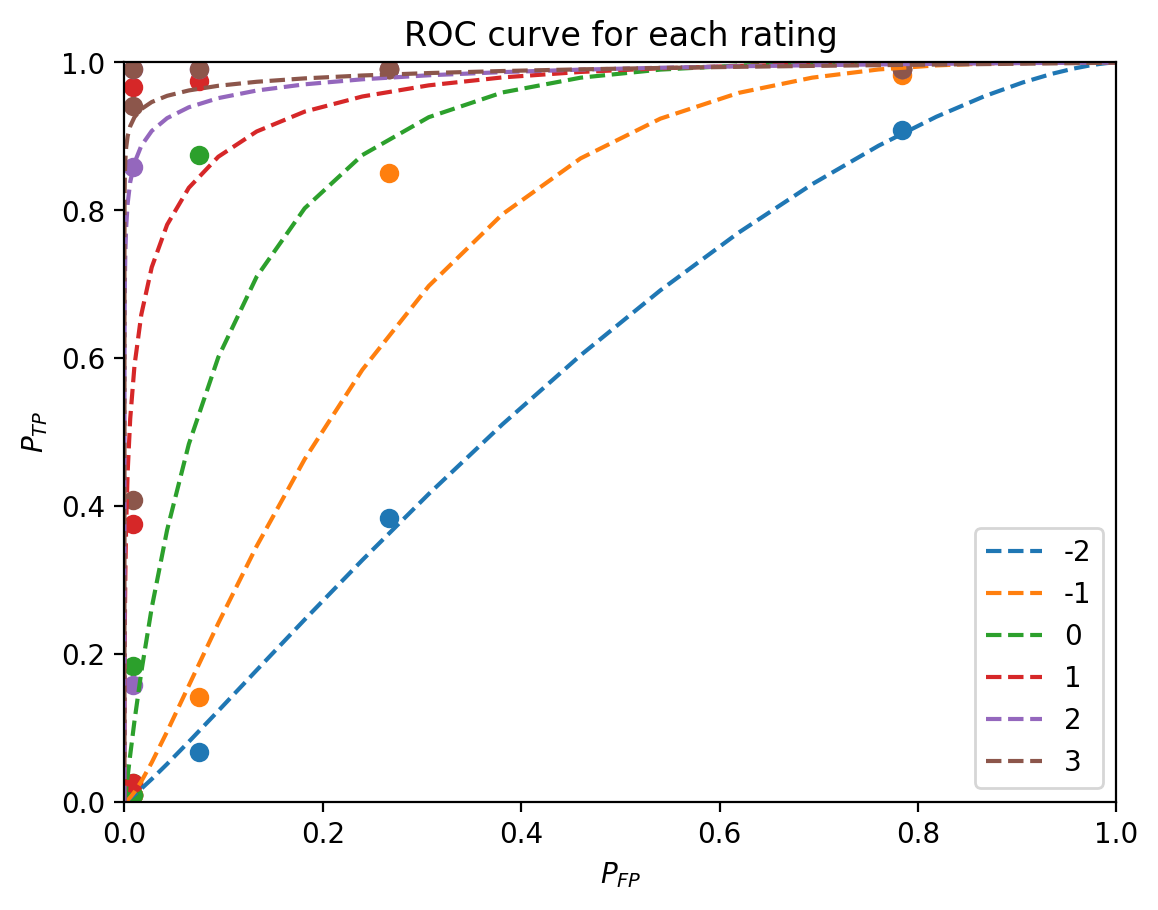

In [66]:
FP = stats.norm.ppf(FPr)
plt.figure()
for rate in range(6):
    TP = stats.norm.ppf(TPr[rate])
    a, b, _, _, _ = stats.linregress(FP,TP)
    rocx, rocy = abline(a, b)
    ROCx = stats.norm.cdf(rocx)
    ROCy = stats.norm.cdf(rocy)
    plt.scatter(stats.norm.cdf(FP), stats.norm.cdf(TP))
    plt.plot(ROCx, ROCy, '--',label=rate-2)
plt.xlabel('$P_{FP}$')
plt.ylabel('$P_{TP}$')
plt.title('ROC curve for each rating')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

In [9]:
def AUC(mu, sigma):
    '''Area Under the Curve (AUC) of the ROC curve when it is not probit transformed.'''
    return stats.norm.cdf(mu / np.sqrt(1 + sigma**2))
A = AUC(a, b)
A

0.5623855599895861

[26, 62, 23, 8, 1, 0, 0]
c_24:  -2.3087754040026365
sigma_24:  1.2528278311990166
p_guess_24:  0.1828918990092371
p_lapse_24:  0.0
[11, 63, 38, 8, 0, 0, 0]
c_24:  -2.4461926182645004
sigma_24:  1.1076147634710032
p_guess_24:  0.07911534024792849
p_lapse_24:  0.027690369086774972
[2, 16, 85, 17, 0, 0, 0]
c_24:  -1.9950582962972943
sigma_24:  0.9556583152173681
p_guess_24:  0.0
p_lapse_24:  0.0
[0, 0, 15, 83, 19, 3, 0]
c_24:  -0.5657684491108151
sigma_24:  0.5446696682085348
p_guess_24:  0.0
p_lapse_24:  0.0
[0, 0, 3, 1, 71, 42, 3]
c_24:  0.9637676881806194
sigma_24:  1.163704564641075
p_guess_24:  0.0
p_lapse_24:  0.0
[0, 0, 1, 0, 16, 84, 19]


/var/folders/ps/y9g6w93s4yq873p_6k6r_lc40000gn/T/ipykernel_60989/224596013.py:32: RuntimeWarning: divide by zero encountered in log
  nll += -first_sum + second_sum - ns * np.log(Ps) - (Ns-ns) * np.log(1-Ps)
/var/folders/ps/y9g6w93s4yq873p_6k6r_lc40000gn/T/ipykernel_60989/224596013.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  nll += -first_sum + second_sum - ns * np.log(Ps) - (Ns-ns) * np.log(1-Ps)
/Users/luxonice/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


c_24:  1.2511862638088025
sigma_24:  1.3391092742713364
p_guess_24:  0.09565066244795235
p_lapse_24:  0.03347773185678332
[0, 0, 0, 0, 7, 64, 49]
c_24:  2.228461419316897
sigma_24:  0.8547530126994692
p_guess_24:  0.0
p_lapse_24:  0.0


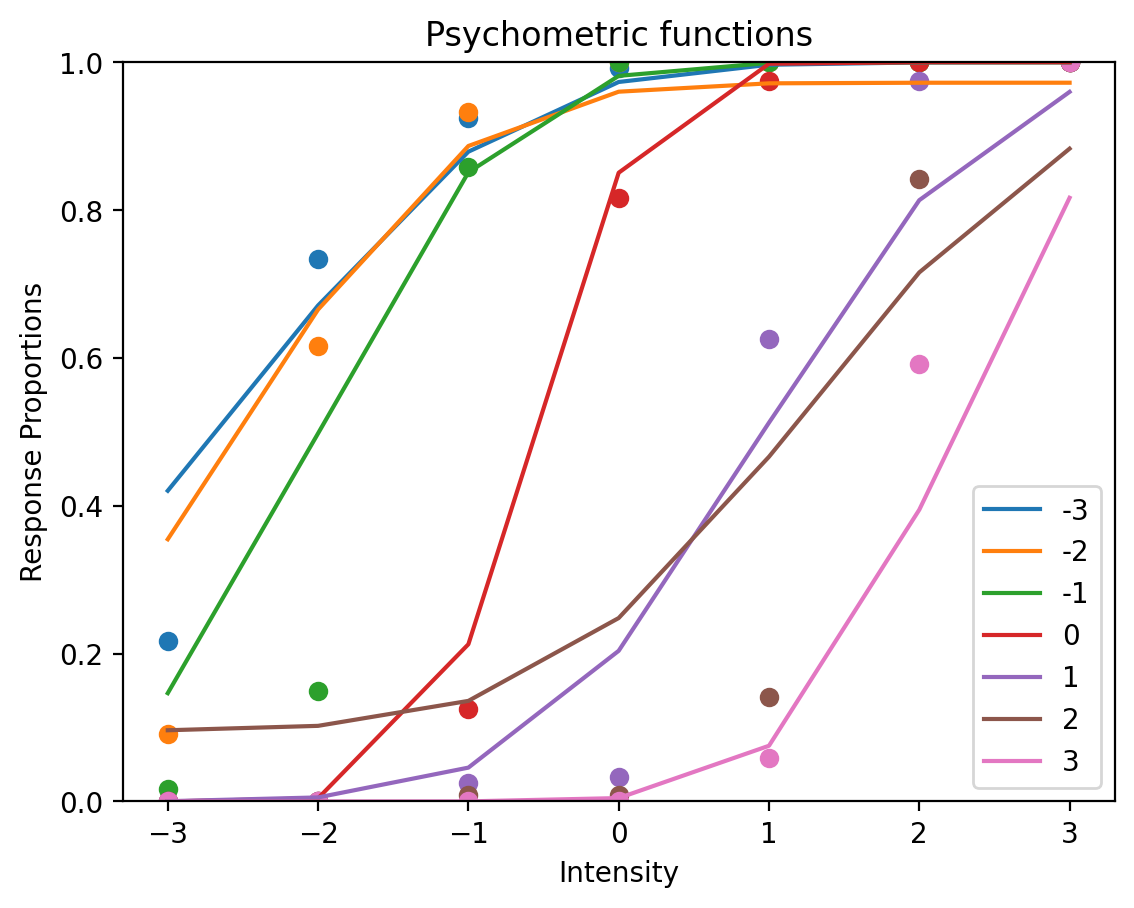

In [68]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def psychometric_function_1_19(I,c,sigma,p_guess,p_lapse):
    return norm.cdf((I-c)/sigma)

def psychometric_function_1_23(I,c,sigma,p_guess,p_lapse):
    return (1-p_guess) * psychometric_function_1_19(I,c,sigma,p_guess,p_lapse) + p_guess

def psychometric_function_1_24(I,c,sigma,p_guess,p_lapse):
    return (1-p_guess-p_lapse) * psychometric_function_1_19(I,c,sigma,p_guess,p_lapse) + p_guess

def nll_24(params, I, trials, responses):
    c, sigma, p_guess, p_lapse = params
    Ns = trials
    nll = 0
    for i in range(len(I)):
        ns = responses[i]
        Ps = psychometric_function_1_24(I[i],c,sigma,p_guess,p_lapse)

        first_sum = np.sum([np.log(x) for x in range(ns+1,Ns+1)])
        second_sum = np.sum([np.log(x) for x in range(1,Ns-ns+1)])
        nll += -first_sum + second_sum - ns * np.log(Ps) - (Ns-ns) * np.log(1-Ps)
    return  nll

# Define bounds for optimization
bounds = [(-3, 3), (1e-14, None), (0,1), (0,1)]

# Probability of guessing
#p_guess = 1/7

# Number of trials
trials = 120

# stimulus intensity
intensity = [-3,-2,-1,0,1,2,3]

# Observed responses
allresponses = df.groupby("Image")["Response"].apply(list)

rating = -4
plt.figure()
for image in ['image_-3.png', 'image_-2.png', 'image_-1.png', 'image_0.png', 'image_1.png', 'image_2.png', 'image_3.png']:
    # Get response counts for this image
    responses = []
    for i in range(intensity[0],intensity[-1]+1):
        responses.append(allresponses[image].count(i))
    print(responses)
    responses = np.cumsum(responses)


    # Update rating
    rating += 1

    # Define the initial guess for optimization
    initial_guess = [find_nearest(responses, trials/2)-3, 2, 1/7, 0.05]

    # Response proportions
    response_proportions = [x/trials for x in responses]

    # Actual optimization
    res_24 = opt.minimize(nll_24, initial_guess, args=(intensity,trials,responses), bounds=bounds) #, method='L-BFGS-B'
    c_24, sigma_24, p_guess_24, p_lapse_24 = res_24.x
    print("c_24: ", c_24)
    print("sigma_24: ", sigma_24)
    print("p_guess_24: ", p_guess_24)
    print("p_lapse_24: ", p_lapse_24)

    # Plot psychometric function
    plt.scatter(intensity, response_proportions)
    plt.plot(intensity,psychometric_function_1_24(intensity,c_24,sigma_24,p_guess_24,p_lapse_24),label=rating)

plt.ylim(0,1)
plt.xlabel('Intensity')
plt.ylabel('Response Proportions')
plt.title('Psychometric functions')
plt.legend()
plt.show()
